In [7]:
import importlib
from typing import Dict
from matplotlib import pyplot as plt
from shared.definitions import TuningResult
from shared.ml_config_core import ModelTrainingResult
from shared import stats_utils
from shared.ml_config_runner import build_production_model_for_tuning_result
from shared import graph
from shared import utils
import seaborn as sns
import pandas as pd
import xgboost
from Draft import feature_builder_v2
import importlib
import xgboost as xgb


In [8]:
VERBOSE = False

In [9]:
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [10]:
# Use this to select the model to train, gennerally there are certain advantages and disadvantages between using different tuning targets:
# e.g. F1 provides better classification accuracy
# PR-AUC however is only slightly worse but has much smoother probabilities which is more
# useful when when selecting thresholds for grades
INCLUDE_MODELS = [
    "LGBMTuneAUCBase",
    # "XGBoostTunePRAUC",
    # "XGBoostTunePRAUCRejected",
    # "CatBoostF1",
    # "XGBoostTuneF1",
]

In [11]:
importlib.reload(feature_builder_v2)
features_matrix = feature_builder_v2.load_datasets_and_prepare_features(drop_meta_data=True, ds_type=feature_builder_v2.DatasetType.BASE)


In [6]:
cv_results_all_models: Dict[str, ModelTrainingResult] = {}

for model_key in INCLUDE_MODELS:
    tuning_result = TuningResult.load_serialized_tuning_result(model_key)

    cv_results = build_production_model_for_tuning_result(
        tuning_result=tuning_result, df=features_matrix
    )
    cv_results_all_models[model_key] = cv_results

    ModelTrainingResult.serialize_model(cv_results, model_key)

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [12]:
for model_key, model_results in cv_results_all_models.items():
    display(model_key)
    display("CV Results:")
    display(pd.Series(model_results.cv_metrics).round(3))
    display("Test Split Evaluation:")
    display(pd.Series(model_results.test_data.metrics).round(3))

'XGBoostTunePRAUC'

'CV Results:'

accuracy               0.920
precision_macro        0.621
recall_macro           0.517
f1_macro               0.516
target_f1              0.075
target_recall          0.042
target_precision       0.317
fbeta_1.5              0.058
fbeta_2.5              0.048
fbeta_4.0              0.045
log_loss               0.285
n_samples           4000.000
dtype: float64

'Test Split Evaluation:'

f1                   0.489
accuracy             0.915
precision            0.523
recall               0.502
recall_class_1       0.013
precision_class_1    0.125
f1_class_1           0.023
fbeta_25             0.014
log_loss             0.290
dtype: float64

The figure layout has changed to tight


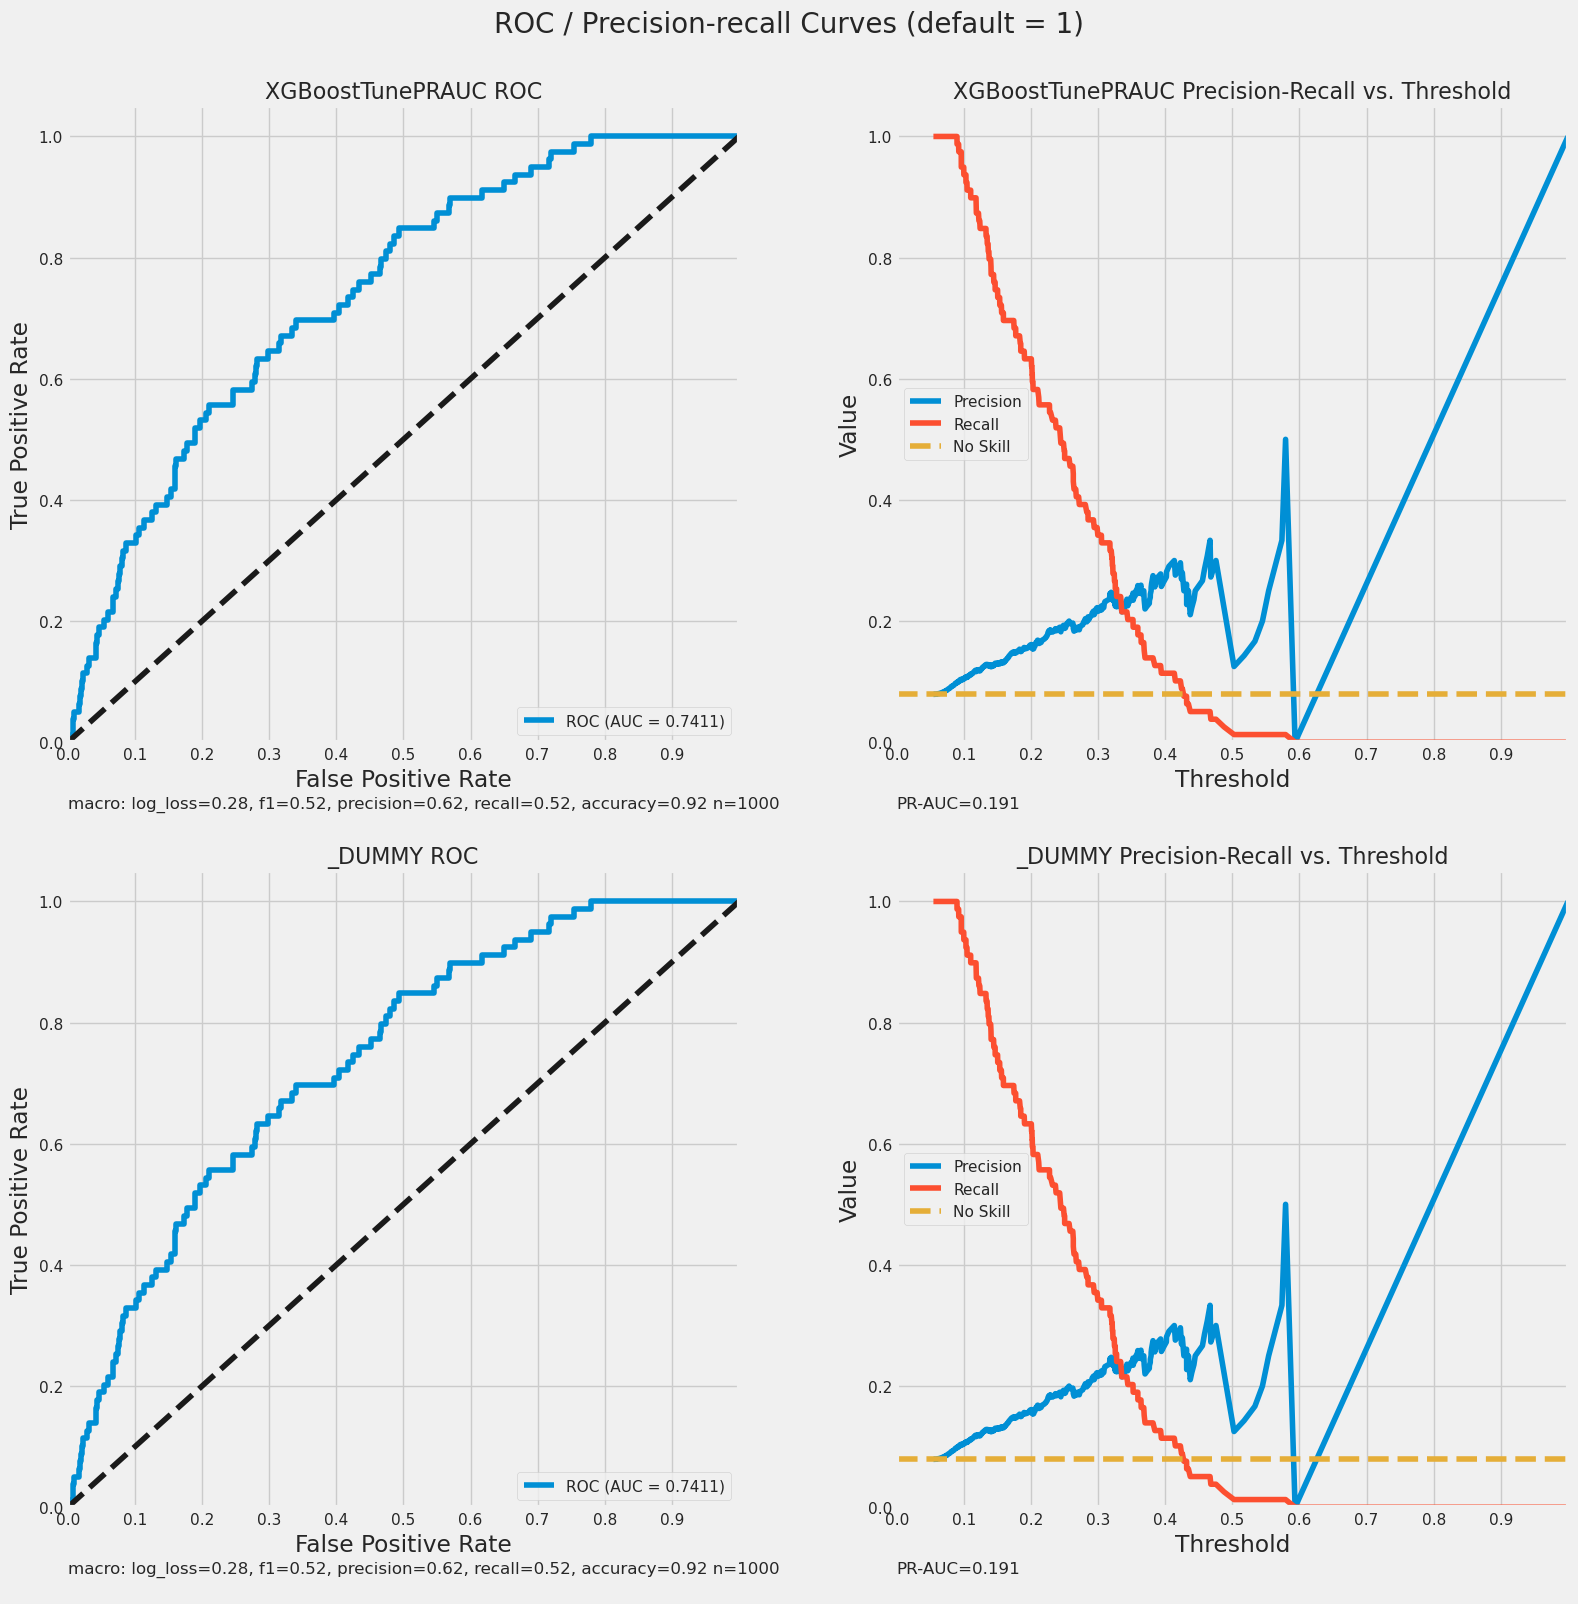

In [14]:
if len(cv_results_all_models) < 2:
    cv_results_all_models["_DUMMY"] = cv_results_all_models[list(cv_results_all_models.keys())[0]]
importlib.reload(graph)
first_model = list(cv_results_all_models.keys())[0]
graph.roc_precision_recal_grid_plot(cv_results_all_models)

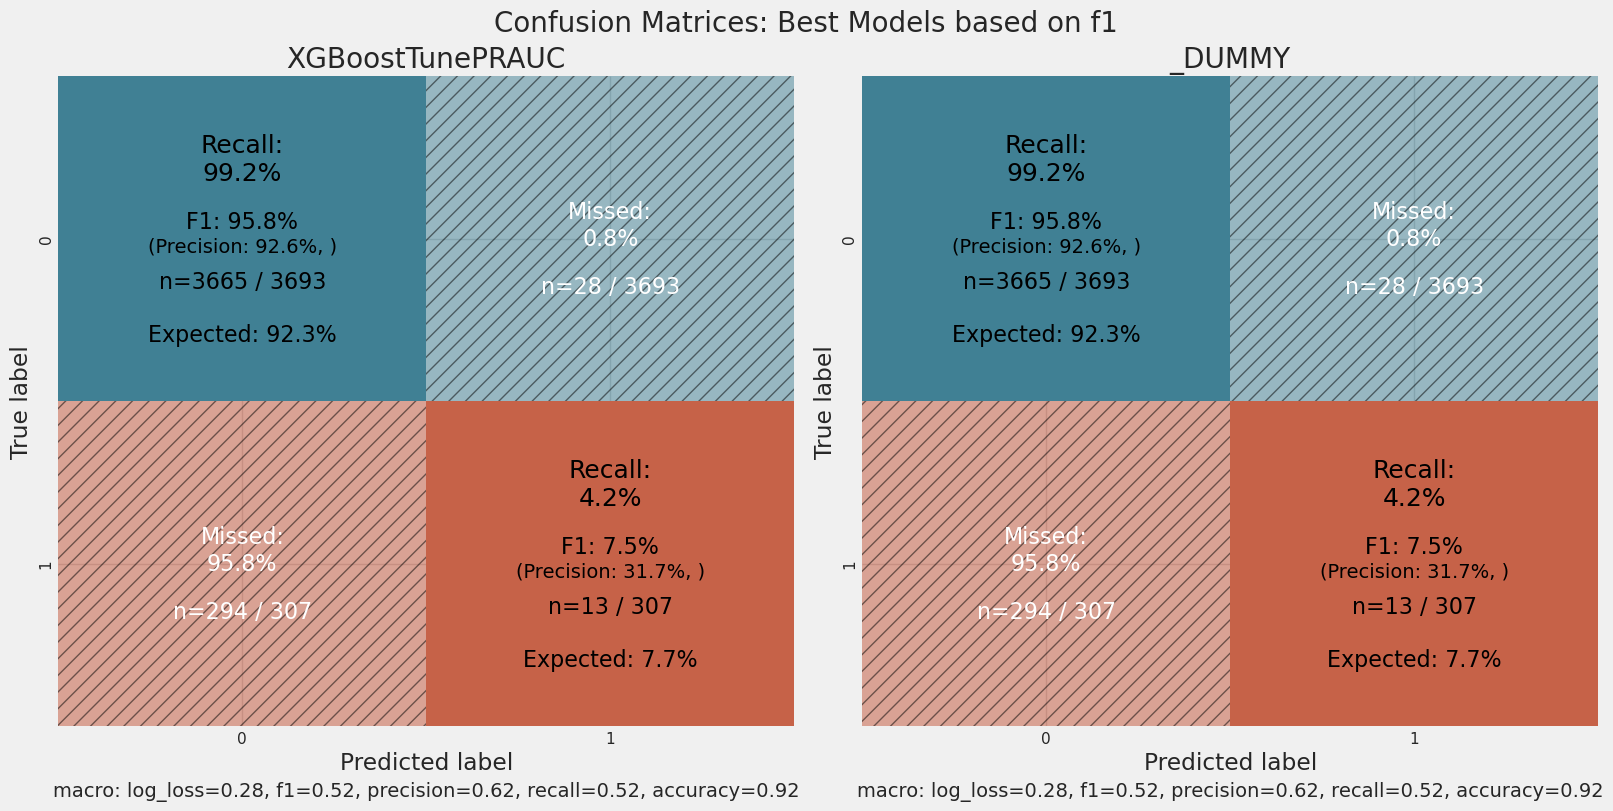

In [15]:
importlib.reload(graph)

n = len(cv_results_all_models)
columns = 2
rows = (n + 1) // columns
height = 8
width = height * columns

fig, axes = plt.subplots(
    rows, columns, figsize=(width, height * rows), constrained_layout=True
)
plt.suptitle("Confusion Matrices: Best Models based on f1", fontsize=20)

axes_flat = axes.flatten()
for i, model_key in enumerate(cv_results_all_models.keys()):
    graph.confusion_matrix_plot_v2(
        cv_results_all_models[model_key].cm_data,
        title=model_key,
        annotations=graph.make_annotations(cv_results_all_models[model_key].cv_metrics),
        ax=axes_flat[i],
    )

# Hide any unused axes
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.show()

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


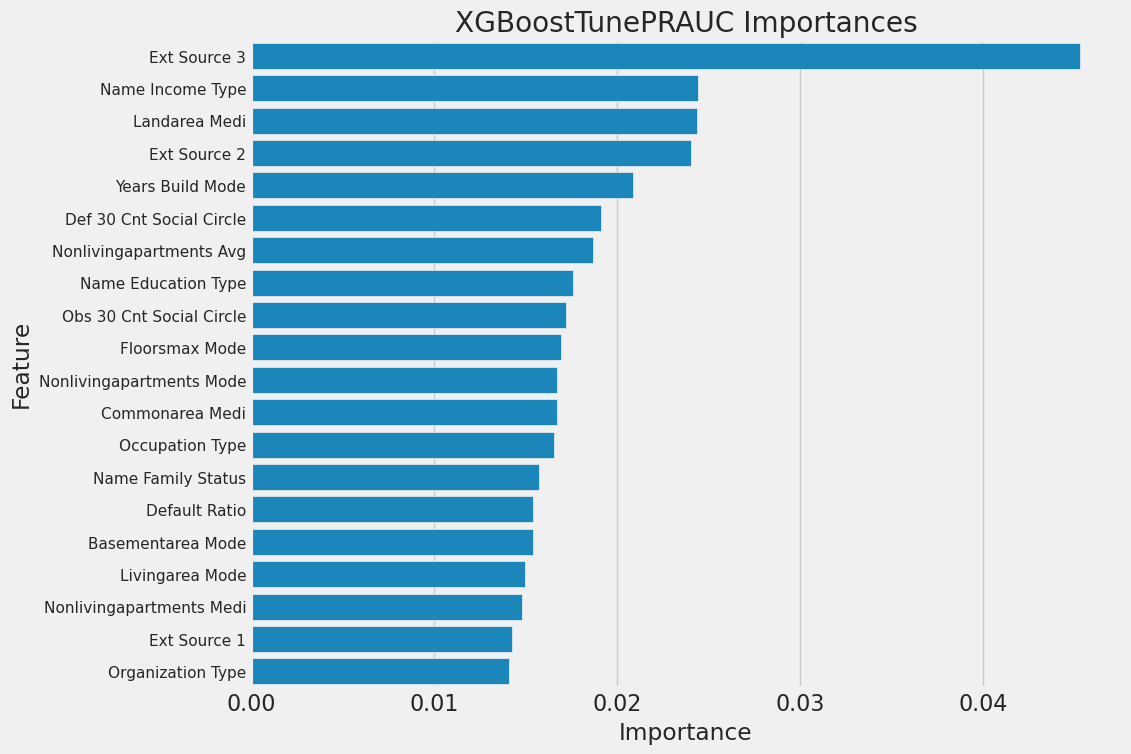

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


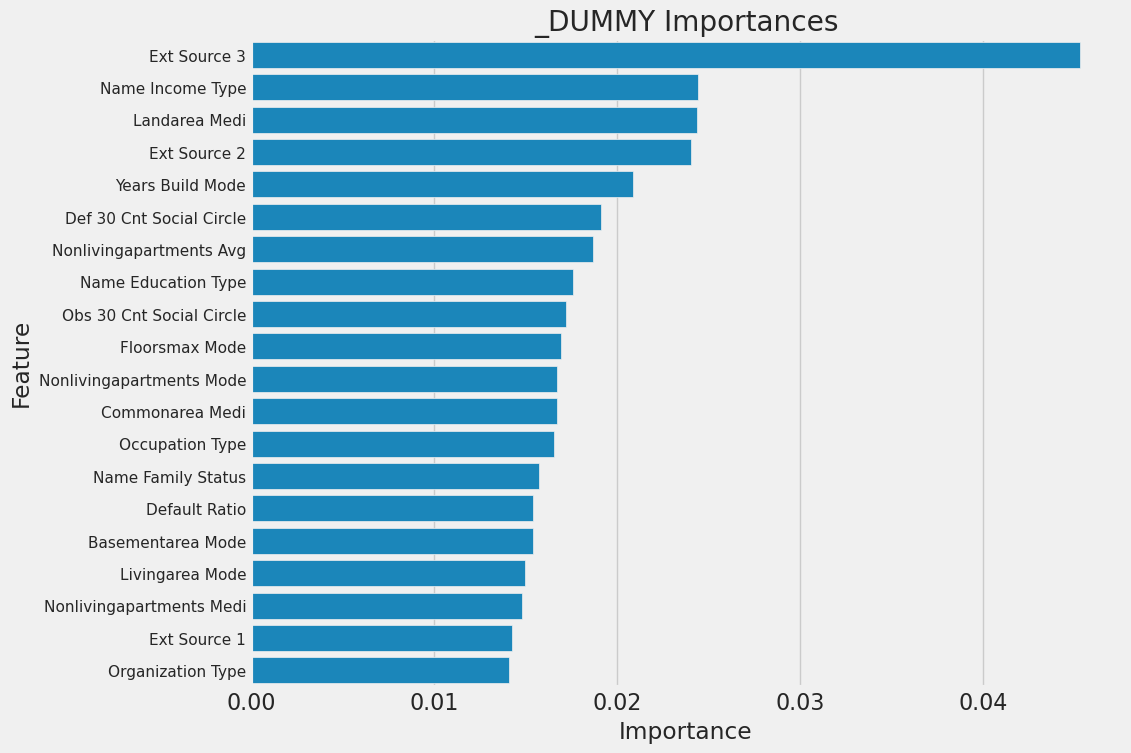

In [19]:
importlib.reload(stats_utils)
for model_key in cv_results_all_models.keys():
    if "Baseline" in model_key:
        continue
    model_config = cv_results_all_models[model_key]
    feature_importances = stats_utils.get_model_feature_importances(
        model_config, features_matrix
    )
    
    feature_importances = feature_importances.sort_values(by="Importance", ascending=False)
    feature_importances = feature_importances.head(20)
    graph.render_feature_importances_chart(
        feature_importances=feature_importances,
        title=f"{model_key} Importances",
    )
    if VERBOSE:
        display(feature_importances)

In [23]:
from shared import pipeline

features_all, labels_all = pipeline._get_features_labels(features_matrix)
X_train, X_test, y_train, y_test = pipeline.get_deterministic_train_test_split(
    features_all, labels_all
)

X_train = X_train.drop(columns=["target__TARGET"])
X_test = X_test.drop(columns=["target__TARGET"])

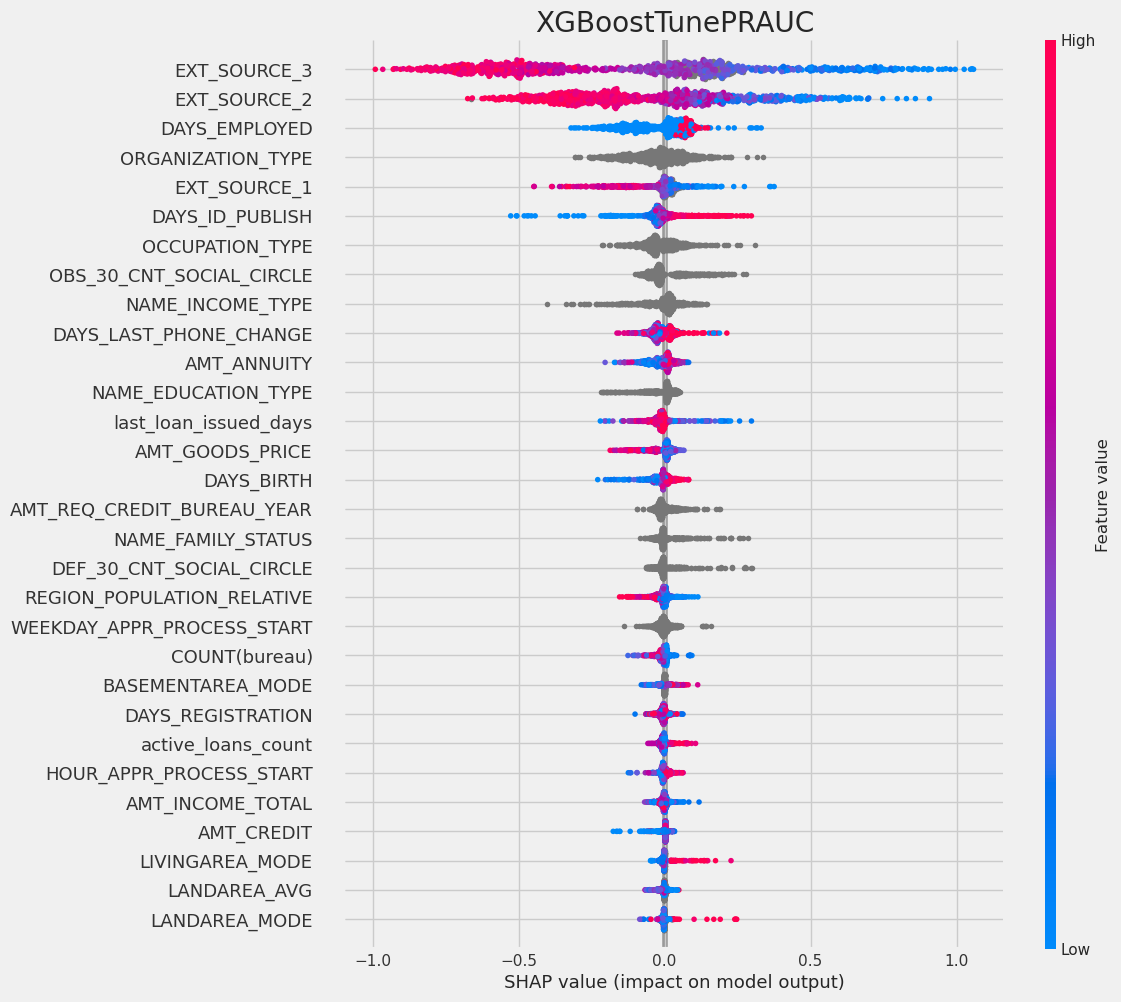

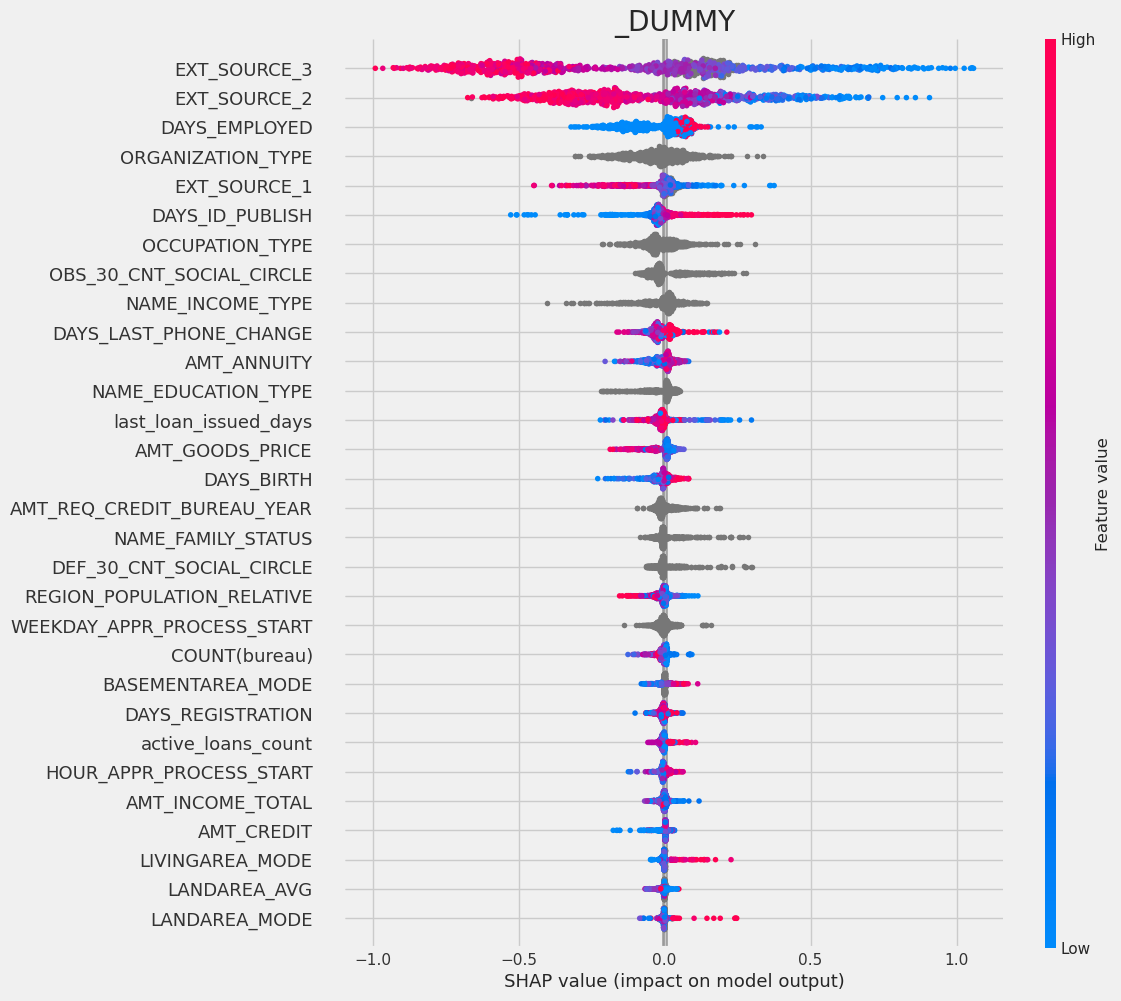

In [24]:
importlib.reload(graph)
for model_key, model_data in cv_results_all_models.items():
    if "Baseline" in model_key:
        continue

    model = cv_results_all_models[model_key].test_data.test_model.named_steps["model"]

    booster_model = model.get_booster()
    shap_values = booster_model.predict(
        xgboost.DMatrix(X_test, enable_categorical=True), pred_contribs=True
    )
    graph.render_shap_plot(shap_values, X_test, model_title=model_key)